In [12]:
## Base Model: Data processing and model training

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import pickle
import os

# 1. Load ddata
def load_data(data_path, iptocountry_path):
    """
    Loads the fraud detection dataset and IP mapping data.

    try:
       data = pd.read_csv(data_path)
        ip_map = pd.read_excel(iptocountry_path)

        # Ensure correct data types of IP mapping
        ip_map['lower_bound_ip_address'] = ip_map['lower_bound_ip_address'].astype(np.int64)
        ip_map['upper_bound_ip_address'] = ip_map['upper_bound_ip_address'].astype(np.int64)
        
        print("Data loaded.")
        return data, ip_map
    except Exception as e:
        print(f"Error loading data: {e}")
        raise
    """

    data = pd.read_csv(data_path)
    ip_map = pd.read_excel(iptocountry_path)
    return data, ip_map
  
    
# 2. Data exploration
def explore_data(data):
    """
    Explores the dataset with visualizations and descriptive statistics.
    """
    print("~~~ Data Overview ~~~")
    print(data.info())
    print(data.describe())

    # Check for missing data
    missing_data = data.isnull().sum()
    if missing_data.sum() == 0:
        print("No missing data.")
    else:
        print("Missing Values:\n", missing_data)
    
    # Count the occurrences of each user_id
    duplicate_users = data[data.duplicated(subset='user_id', keep=False)]

    if not duplicate_users.empty:
        print(f"Found {duplicate_users.shape[0]} duplicate user_id(s):")
        print(duplicate_users[['user_id', 'class']]) 
    else:
        print("No redundant user_ids.")

    print("\nClass Distribution:")
    print(data['class'].value_counts(normalize=True))

    # Visualize class distribution
    #sns.countplot(data['class'])
    #plt.title("Class Distribution")
    #plt.show()

    # Exclude non-numeric columns for correlation
    #print("Data types:")
    #print(data.dtypes)
    #numeric_data = data.select_dtypes(include=['number'])

    # Visualize correlations
    #corr_matrix = numeric_data.corr()
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    #plt.title("Correlation Matrix")
    #plt.show()

# 3. Feature engineering
def feature_engineering(data, ip_map):
    """
    Domain-based engineering
    - Converts timestamps into time-based features
    - Maps IP addresses to countries
    """
    # Parse dates
    data['signup_time'] = pd.to_datetime(data['signup_time'], errors='coerce')
    data['purchase_time'] = pd.to_datetime(data['purchase_time'], errors='coerce')
    
    # Time-based features
    data['signup_hour'] = data['signup_time'].dt.hour
    data['purchase_hour'] = data['purchase_time'].dt.hour
    data['time_diff_minutes'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds() / 60

    # Map IP addresses to countries
    def map_ip_to_country(ip):
        row = ip_map[
            (ip_map['lower_bound_ip_address'] <= ip) & 
            (ip_map['upper_bound_ip_address'] >= ip)
        ]
        return row['country'].values[0] if not row.empty else "Unknown"

    data['country'] = data['ip_address'].apply(map_ip_to_country)

    # Encode categorical variables
    #data = pd.get_dummies(data, columns=['source', 'browser', 'country', 'sex'], drop_first=True)

    # Encode categorical variables
    le = LabelEncoder()
    for col in ['source', 'browser', 'sex', 'country']:  # Make sure these columns exist in your dataset
        if col in data.columns:
            data[col] = le.fit_transform(data[col])

    # Drop unnecessary columns
    data = data.drop(columns=['Unnamed: 0', 'user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address'])

    # Clean column names
    data.columns = data.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)  # replace non-alphanumeric characters with '_'

    return data

# 4. Handling imbalanced for the minority class, Fraudulent (1)
def handle_imbalance(X, y):
    """
    Generates synthatic samples using SMOTE k_neighbors=3
    """
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# 5. Model training
def train_model(model_name, model, X_train, y_train):
    """
    Trains a model.
    """
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    return model

# 6. Calculate balance accuracy
def balanced_accuracy(y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)   
        TP = cm[1, 1]  # True Positives
        FN = cm[1, 0]  # False Negatives
        TN = cm[0, 0]  # True Negatives
        FP = cm[0, 1]  # False Positives
        
        # Compute recall for both classes
        recall_pos = TP / (TP + FN) if (TP + FN) != 0 else 0
        recall_neg = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        # Compute balance accuracy
        return (recall_pos + recall_neg) / 2

# 7. Model evaluation
def evaluate_model(model_name, model, X_test, y_test):
    """
    Evaluates a trained model.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred)
    #recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    bal_acc = balanced_accuracy(y_test, y_pred)

    # Store the performance metrics
    model_performance[model_name] = {
        'Accuracy': accuracy,
        #'Precision': precision,
        #'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': auc if auc is not None else 0,
        'PR AUC': pr_auc if pr_auc is not None else 0,
        'Bal Acc': bal_acc
    }

    return model_performance

# 8. Save trained models
def save_all_models(models, folder):
    """
    Saves all trained models to individual files in a specified folder.
    
    Parameters:
    - models: Dictionary of trained models with keys as model names and values as model objects.
    - folder: Directory where the models will be saved. Defaults to "saved_models".
    """
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Save each model
    for model_name, model in models.items():
        filename = os.path.join(folder, f"{model_name}.pkl")
        with open(filename, "wb") as f:
            pickle.dump(model, f)
        print(f"Model '{model_name}' saved to {filename}")

# 9. Table for model performance
def best_model_table(model_performance):
    # Convert model performance dictionary to a pandas DataFrame
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
        
    # Highlight the best model 
    best_model_acc = performance_df['Accuracy'].idxmax()  
    best_model_f1 = performance_df['F1 Score'].idxmax()  
    best_model_auc = performance_df['ROC AUC'].idxmax()  
    best_model_pr_auc = performance_df['PR AUC'].idxmax()  
    best_model_bal_acc = performance_df['Bal Acc'].idxmax()  

    performance_table = performance_df.style
    
    # Highlight the best model in yellow
    performance_table = performance_table.apply(
        lambda x: ['background-color: yellow' if v == performance_df.loc[best_model_acc, 'Accuracy'] else '' for v in x],
        subset=['Accuracy'], axis=1
    )
    performance_table = performance_table.apply(
        lambda x: ['background-color: yellow' if v == performance_df.loc[best_model_f1, 'F1 Score'] else '' for v in x],
        subset=['F1 Score'], axis=1
    )
    performance_table = performance_table.apply(
        lambda x: ['background-color: yellow' if v == performance_df.loc[best_model_auc, 'ROC AUC'] else '' for v in x],
        subset=['ROC AUC'], axis=1
    )  
    performance_table = performance_table.apply(
        lambda x: ['background-color: yellow' if v == performance_df.loc[best_model_pr_auc, 'PR AUC'] else '' for v in x],
        subset=['PR AUC'], axis=1
    )
    performance_table = performance_table.apply(
        lambda x: ['background-color: yellow' if v == performance_df.loc[best_model_bal_acc, 'Bal Acc'] else '' for v in x],
        subset=['Bal Acc'], axis=1
    )

    return performance_table

RANDOM_STATE = 42

# Machine learning models
MODELS = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced', max_iter=5000, penalty='l2'),
    #"Support Vector Machine": SVC(kernel='linear', random_state=RANDOM_STATE, probability=True, class_weight="balanced")
    #"Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=6, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', eval_metric='logloss', n_estimators=100, max_depth=6, n_jobs=-1),
    "HistGradient Boosting": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
}

# - Logistic Regression: A baseline model for linear relationships, with class weights to address imbalance.
# - Support Vector Machine: Effective in high-dimensional spaces and incorporates class weights to balance the dataset.
# - Random Forest: Handles imbalanced datasets well and is robust to overfitting.
# - XGBoost: Known for high performance in classification problems, especially imbalanced ones.
# - HistGradient Boosting: An ensemble method that works well with structured data.
# - LightGBM: Efficient with large datasets and capable of handling imbalance.

# Dictionary to store performance metrics
model_performance = defaultdict(dict)

# Main workflow
def main():
    
    #data_path = r"Fraud_Data.csv"
    #iptocountry_path = r"IpAddress_to_Country.xlsx"

    data_path = r"C:\Users\azlan\OneDrive\Documents\Haliza\GITHUB_FOLDERS\fraud_detection\Fraud_Data.csv"
    iptocountry_path = r"C:\Users\azlan\OneDrive\Documents\Haliza\GITHUB_FOLDERS\fraud_detection\IpAddress_to_Country.xlsx"

    # Load and clean data
    data, ip_mapping = load_data(data_path, iptocountry_path)

    # Explore the data
    explore_data(data)

    # Feature engineering
    processed_data = feature_engineering(data, ip_mapping)

    # Split data
    X = processed_data.drop(columns=['class'])
    y = processed_data['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Handle imbalance
    X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)

    trained_models = {}
    model_performance = {}  

    # Train and evaluate models
    for model_name, model in MODELS.items():
        # Train the model
        trained = train_model(model_name, model, X_train_resampled, y_train_resampled)
        
        # Store the trained model
        trained_models[model_name] = trained
        
        # Get the specific trained model from the dictionary
        trained_model = trained_models[model_name]
        
        # Evaluate the model performance on the test set
        model_performance = evaluate_model(model_name, trained_model, X_test, y_test)
    
    # Save all trained models
    save_all_models(trained_models, folder="saved_base_models")
    
    # Best model performance
    best_table = best_model_table(model_performance)
    display(best_table)

    return trained_models, X_train_resampled, y_train_resampled, X_test, y_test

if __name__ == "__main__":
    trained_models, X_train_resampled, y_train_resampled, X_test, y_test = main()

~~~ Data Overview ~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      120000 non-null  int64  
 1   user_id         120000 non-null  int64  
 2   signup_time     120000 non-null  object 
 3   purchase_time   120000 non-null  object 
 4   purchase_value  120000 non-null  int64  
 5   device_id       120000 non-null  object 
 6   source          120000 non-null  object 
 7   browser         120000 non-null  object 
 8   sex             120000 non-null  object 
 9   age             120000 non-null  int64  
 10  ip_address      120000 non-null  float64
 11  class           120000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 11.0+ MB
None
          Unnamed: 0        user_id  purchase_value            age  \
count  120000.000000  120000.000000   120000.000000  120000.000000   
mean    75639.1

,Accuracy,F1 Score,ROC AUC,PR AUC,Bal Acc
Logistic Regression,0.658667,0.276964,0.743154,0.375652,0.675581
XGBoost,0.889333,0.496015,0.772673,0.628823,0.750742
HistGradient Boosting,0.889167,0.497544,0.777057,0.635421,0.752639
LightGBM,0.888083,0.491865,0.776733,0.630051,0.748660


In [10]:
## Tuned Model: Hyperparameter tuning using RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from scipy.stats import uniform, randint

def tune_model(model_name, model, X_train, y_train, param_grid):
    """
    Hyperparameter tuning using GridSearchCV.
    """
    print(f"Tuning {model_name}...")
    
    # RandomSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # GridSearchCV with cross-validation
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
    #grid_search.fit(X_train, y_train)
    #best_model = grid_search.best_estimator_
    #best_params = grid_search.best_params_
    print(f"Best hyperparameters for {model_name}: {best_params}")
    
    return best_model

# Hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    "XGBoost": {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.3]
    },
    "HistGradient Boosting": {
        'learning_rate': uniform(0.01, 0.2),
        'max_iter': randint(100, 1000),
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': randint(10, 50),
        'max_leaf_nodes': randint(15, 127),
        'l2_regularization': uniform(0.0, 10.0),
        'max_bins': randint(127, 511),
        'class_weight': [None, 'balanced']
    },
    "LightGBM": {
        'n_estimators': [50, 100, 150],  # Number of trees
        'learning_rate': [0.01, 0.1, 0.3],  # Contribution of each tree
        'max_depth': [3, 6, 9],  # Maximum depth of the tree
        'num_leaves': [31, 50, 100],  # Number of leaves per tree
        'subsample': [0.8, 1.0],  # Fraction of data to use for each tree
        'colsample_bytree': [0.8, 1.0],  # Fraction of features to use at each split
        'boosting_type': ['gbdt', 'dart'],  # Boosting types
        'scale_pos_weight': [1, 10, 50, 100],  # Adjust weight of positive class
        'class_weight': ['balanced'],  # Automatically adjust class weights for imbalanced data
    }
}

def main():
    
    # Paths to datasets
    #data_path = r"Fraud_Data.csv"
    #iptocountry_path = r"IpAddress_to_Country.xlsx"

    data_path = r"C:\Users\azlan\OneDrive\Documents\Haliza\GITHUB_FOLDERS\fraud_detection\Fraud_Data.csv"
    iptocountry_path = r"C:\Users\azlan\OneDrive\Documents\Haliza\GITHUB_FOLDERS\fraud_detection\IpAddress_to_Country.xlsx"

    # Load and clean data
    data, ip_mapping = load_data(data_path, iptocountry_path)

    # Explore the data
    explore_data(data)

    # Feature engineering
    processed_data = feature_engineering(data, ip_mapping)

    # Split data
    X = processed_data.drop(columns=['class'])
    y = processed_data['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Handle imbalance
    X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)

    # Initialize an empty dictionary to store models and their performance
    trained_models = {}
    model_performance = {}  

    # Train and evaluate models with hyperparameter tuning
    for model_name, model in MODELS.items():
        # Get the hyperparameter grid for the model
        param_grid = param_grids.get(model_name, {})
        
        # Tune the model using GridSearchCV
        tuned_model = tune_model(model_name, model, X_train_resampled, y_train_resampled, param_grid)
        
        # Store the trained and tuned model in the dictionary
        trained_models[model_name] = tuned_model
        
        # Evaluate the model performance on the test set
        model_performance = evaluate_model(model_name, tuned_model, X_test, y_test)
    
    # Save all trained models
    save_all_models(trained_models, folder ="saved_tuned_models")
    
    # Best model performance
    best_table = best_model_table(model_performance)
    display(best_table)

    return trained_models

if __name__ == "__main__":
    trained_models = main()

~~~ Data Overview ~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      120000 non-null  int64  
 1   user_id         120000 non-null  int64  
 2   signup_time     120000 non-null  object 
 3   purchase_time   120000 non-null  object 
 4   purchase_value  120000 non-null  int64  
 5   device_id       120000 non-null  object 
 6   source          120000 non-null  object 
 7   browser         120000 non-null  object 
 8   sex             120000 non-null  object 
 9   age             120000 non-null  int64  
 10  ip_address      120000 non-null  float64
 11  class           120000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 11.0+ MB
None
          Unnamed: 0        user_id  purchase_value            age  \
count  120000.000000  120000.000000   120000.000000  120000.000000   
mean    75639.1

,Accuracy,F1 Score,ROC AUC,PR AUC,Bal Acc
Logistic Regression,0.657125,0.276571,0.743206,0.369994,0.675526
XGBoost,0.902750,0.521525,0.773239,0.626992,0.751183
HistGradient Boosting,0.895000,0.503937,0.773846,0.628034,0.748498
LightGBM,0.156833,0.178067,0.775012,0.630235,0.522605


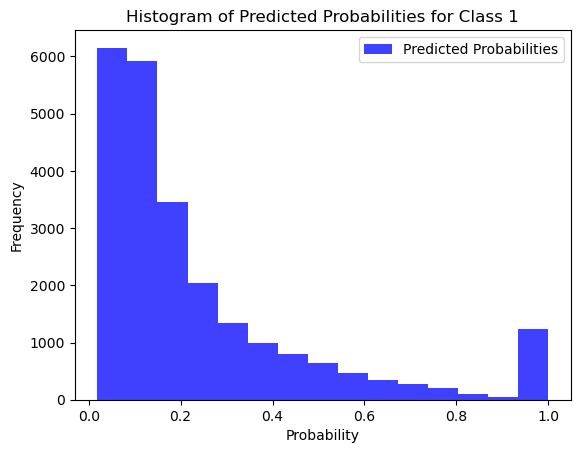

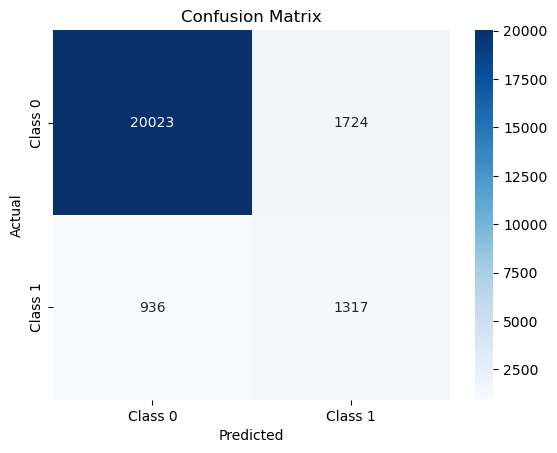

Accuracy: 0.8892
F1 Score: 0.4975
ROC AUC Score: 0.7771
Precision-Recall AUC: 0.6354
Balanced Accuracy: 0.7526
Confusion Matrix:
 [[20023  1724]
 [  936  1317]]


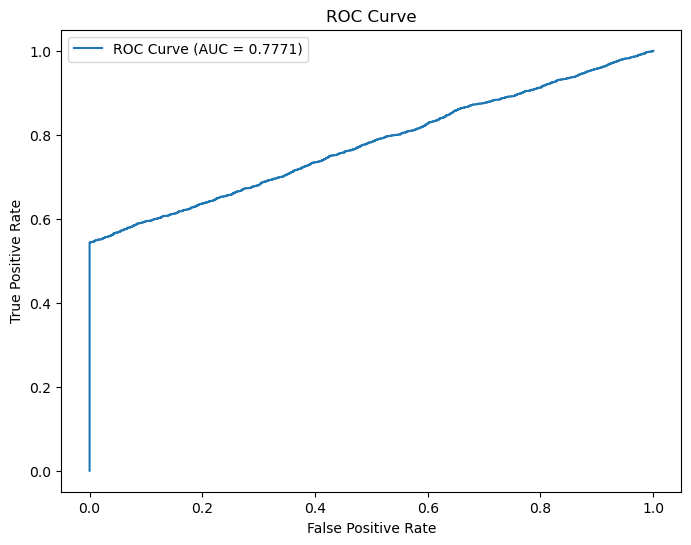

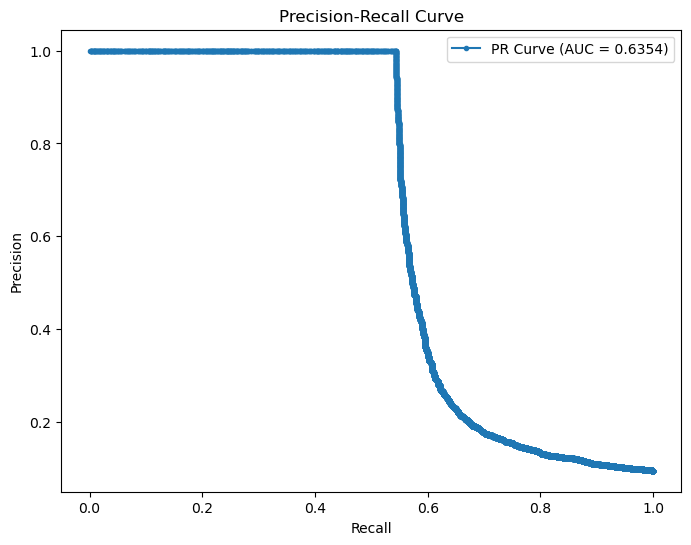

In [5]:
## Best model: Visualize and evaluate the best model

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

def load_model(filepath):
    """
    Load a saved model from a file.
    """
    with open(filepath, "rb") as f:
        return pickle.load(f)
    
best_model = load_model("saved_models/HistGradient Boosting.pkl")
y_pred = best_model.predict(X_test)

# Histogram of predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
plt.hist(y_proba, bins=15, alpha=0.75, color='blue', label='Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Class 1')
plt.legend(loc='best')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else None
cm = confusion_matrix(y_test, y_pred)
bal_acc = balanced_accuracy(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")    
if auc is not None:
    print(f"ROC AUC Score: {auc:.4f}")
if pr_auc is not None:
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print("Confusion Matrix:\n", cm)

# ROC Curve
if auc is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve")
    plt.legend()
    plt.show()

# Precision-Recall Curve
    if pr_auc is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve')
        plt.legend()
        plt.show()

In [ ]:
## Testing Out-of-sample dataset

from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import pickle

def test_out_of_sample(model, data_path, iptocountry_path, target_column, process_data_pipeline):
    """
    Test the out-of-sample data using a loaded model and return evaluation metrics.

    Parameters:
    - model: Trained and loaded model object.
    - data_path: Path to the out-of-sample dataset (CSV file).
    - target_column: The name of the target column in the dataset.
    - process_data_pipeline: A function to preprocess the data (e.g., feature engineering, scaling).

    Returns:
    - acc: Accuracy.
    - f1: F1 score of the predictions.
    - roc_auc: ROC AUC score.
    - pr_auc: Precision-Recall AUC score.
    - bal_acc: Balanecd Accuracy
    """
    
    # Preprocess the features using the feature pipeline
    processed_data = process_data_pipeline(data_path, iptocountry_path)

    X_out_sample = processed_data.drop(columns=[target_column])
    y_out_sample = processed_data[target_column]

    # Make predictions
    predictions = model.predict(X_out_sample)

    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X_out_sample)[:, 1]
    else:
        raise ValueError("The model does not support probability prediction.")

    # Compute evaluation metrics
    acc = accuracy_score(y_out_sample, predictions)
    f1 = f1_score(y_out_sample, predictions)
    roc_auc = roc_auc_score(y_out_sample, probabilities)
    precision, recall, _ = precision_recall_curve(y_out_sample, probabilities)
    pr_auc = auc(recall, precision)
    bal_acc = balanced_accuracy(y_out_sample, predictions)
    
    return acc, f1, roc_auc, pr_auc, bal_acc

# Test out-of-sample data
if __name__ == "__main__":

    # Load the base models
    #loaded_model = load_model("saved_based_models/Logistic Regression.pkl")
    #loaded_model = load_model("saved_based_models/XGBoost.pkl")
    loaded_model = load_model("saved_based_models/HistGradient Boosting.pkl")
    #loaded_model = load_model("saved_based_models/LightGBM.pkl")

    # Load the tuned models
    #loaded_model = load_model("saved_tuned_models/Logistic Regression.pkl")
    #loaded_model = load_model("saved_tuned_models/XGBoost.pkl")
    #loaded_model = load_model("saved_tuned_models/HistGradient Boosting.pkl")
    #loaded_model = load_model("saved_tuned_models/LightGBM.pkl")

    
    # Define a placeholder data processing pipeline
    def process_data_pipeline(data_path, iptocountry_path):
        # Apply the same preprocessing steps used in training
        data, ip_mapping = load_data(data_path, iptocountry_path)
        data = feature_engineering(data, ip_mapping)
        return data

    acc, f1, roc_auc, pr_auc, bal_acc = test_out_of_sample(
        loaded_model,
        data_path=r"out_of_sample_data.csv",
        iptocountry_path = r"IpAddress_to_Country.xlsx",
        target_column="class",
        process_data_pipeline=process_data_pipeline
    )
    
    # Print evaluation metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Bal Acc: {bal_acc:.4f}")


Accuracy: 0.5222
F1 Score: 0.2362
ROC AUC: 0.7776
PR AUC: 0.6225
Bal Acc: 0.6409
